#SADT combined data

Continuation of the analysis started in the EDA notebook

Here use the combined dataframe (1 hour interval) to take a look and decide how to handle missing values

In [2]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import date


In [3]:
# chose the csv files from local directory (csv with combined data downloaded in eda notebook)
# (click on the "choose files" button after running the cell)
from google.colab import files
uploaded = files.upload()

Saving gbt_combined_data_1hr_with5am.csv to gbt_combined_data_1hr_with5am.csv


In [29]:
# save raw data to dataframes

import io

# old file, without 5am column
# combined_data_1hr_df = pd.read_csv(
#     io.BytesIO(uploaded['gbt_combined_data_1hr.csv']), 
#     parse_dates = ['DateAndTimeIndex','fact_date','fact_time'],
#              index_col = 'DateAndTimeIndex')

combined_data_1hr_df = pd.read_csv(
    io.BytesIO(uploaded['gbt_combined_data_1hr_with5am.csv']), 
    parse_dates = ['DateAndTimeIndex','fact_date','fact_time'],
             index_col = 'DateAndTimeIndex')



### shape of input data

In [30]:
# only take time part of the fact_time column
combined_data_1hr_df.fact_time = pd.to_datetime(combined_data_1hr_df.fact_time).dt.time

In [31]:
combined_data_1hr_df.columns

Index(['Unnamed: 0', 'fact_date', 'fact_time', 'read_value_406',
       'read_value_427', 'read_value_466', 'read_value_173', 'read_value_469',
       'read_value_146', 'read_value_185', 'temp_5am_173'],
      dtype='object')

In [32]:
combined_data_1hr_df.dtypes

Unnamed: 0                 int64
fact_date         datetime64[ns]
fact_time                 object
read_value_406           float64
read_value_427           float64
read_value_466           float64
read_value_173           float64
read_value_469           float64
read_value_146           float64
read_value_185           float64
temp_5am_173             float64
dtype: object

In [33]:
combined_data_1hr_df.head()

,Unnamed: 0,fact_date,fact_time,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185,temp_5am_173
DateAndTimeIndex,,,,,,,,,,,
2018-10-03 00:00:00,0,2018-10-03,00:00:00,21.250594,24.703298,24.131833,-3.416478,NaN,NaN,NaN,-3.551241
2018-10-03 01:00:00,1,2018-10-03,01:00:00,21.184786,24.492113,23.802965,-3.351986,NaN,NaN,NaN,-3.551241
2018-10-03 02:00:00,2,2018-10-03,02:00:00,21.124748,24.360717,23.595771,-3.145735,NaN,NaN,NaN,-3.551241
2018-10-03 03:00:00,3,2018-10-03,03:00:00,21.054325,24.247273,23.446922,-3.457851,NaN,NaN,NaN,-3.551241
2018-10-03 04:00:00,4,2018-10-03,04:00:00,21.998112,40.407005,40.448446,-3.398226,NaN,NaN,NaN,-3.551241


In [34]:
# looks like Unnamed column is just an old range index, drop the column
combined_data_1hr_df.drop(columns='Unnamed: 0',inplace=True)
combined_data_1hr_df.head()

,fact_date,fact_time,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185,temp_5am_173
DateAndTimeIndex,,,,,,,,,,
2018-10-03 00:00:00,2018-10-03,00:00:00,21.250594,24.703298,24.131833,-3.416478,NaN,NaN,NaN,-3.551241
2018-10-03 01:00:00,2018-10-03,01:00:00,21.184786,24.492113,23.802965,-3.351986,NaN,NaN,NaN,-3.551241
2018-10-03 02:00:00,2018-10-03,02:00:00,21.124748,24.360717,23.595771,-3.145735,NaN,NaN,NaN,-3.551241
2018-10-03 03:00:00,2018-10-03,03:00:00,21.054325,24.247273,23.446922,-3.457851,NaN,NaN,NaN,-3.551241
2018-10-03 04:00:00,2018-10-03,04:00:00,21.998112,40.407005,40.448446,-3.398226,NaN,NaN,NaN,-3.551241


---
---
##Scaled sensor data and correlation between columns

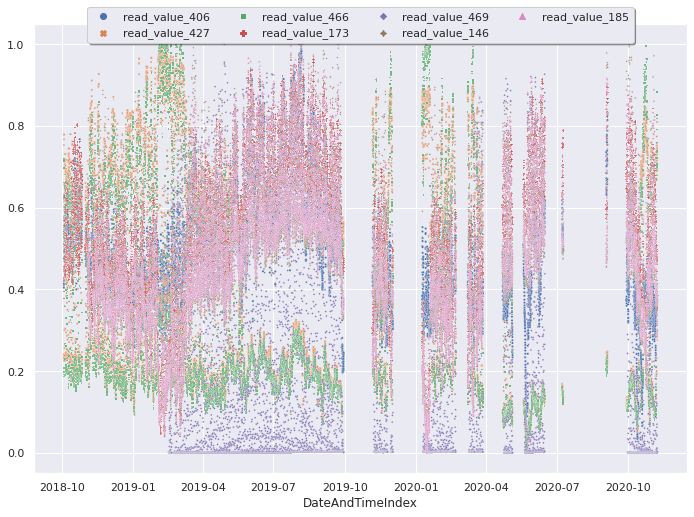

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# take only columns with sensor readings
sensor_data_1hr = combined_data_1hr_df[[col for col in combined_data_1hr_df if col.startswith('read_value_')]]
# min max scaling on all the sensor columns
sensor_data_1hr_scaled = (sensor_data_1hr - sensor_data_1hr.min()) / \
                      (sensor_data_1hr.max() - sensor_data_1hr.min())

sns.scatterplot(data=sensor_data_1hr_scaled, s=5).set_title('normalized sensor data, 1 hour interval')
# plt.legend(title='sensor_id', fontsize='14', title_fontsize='14')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)

In [35]:
corr_1hr = sensor_data_1hr.corr()
corr_1hr.style.background_gradient(cmap='Spectral')
# For reference:
# 406 - 2nd floor temp
# 427/466 - HRV supplied to north/south side of building, respectively
# 173 - outside air temp
# 469 - carport
# 146/185 - solar wall/roof sensor, respectively

,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185
read_value_406,1.000000,-0.309731,-0.307734,0.594088,0.218031,0.588553,0.628115
read_value_427,-0.309731,1.000000,0.991935,-0.716878,-0.288819,-0.687327,-0.717331
read_value_466,-0.307734,0.991935,1.000000,-0.718942,-0.276795,-0.676539,-0.712130
read_value_173,0.594088,-0.716878,-0.718942,1.000000,0.485989,0.867374,0.954221
read_value_469,0.218031,-0.288819,-0.276795,0.485989,1.000000,0.690528,0.582113
read_value_146,0.588553,-0.687327,-0.676539,0.867374,0.690528,1.000000,0.946866
read_value_185,0.628115,-0.717331,-0.712130,0.954221,0.582113,0.946866,1.000000


###**NOTES**

Overall, all inputs somewhat correlate to each other:

- correlation between sensors 427 and 466 is really high, which is expected as they have the same source
  - in theory, since there is separate control on each of the HRV input lines to the north and south side of the building, the correlation between the readings on the two sensor may not be always this high 
- solar wall/roof highly correlated with outside air as well, as well as (to a lesser degree) to the carport data
  - again, somewhat expected as all these readings are influenced by the intensity of the sun

Also, they all correlate to the target column:
- indicates that the model should be easily predictive?
- the temperature on the second floor is inversely proportional to the heat input 
  - probably just indicates that in the summer, when the temperatures on the 2nd floor are at their highest, there is no need to pump heat into the building, so HRV input is at its lowest
- carport data shows low correlation to 2nd floor temperature, which is a bit unexpected since carport power is related to the intensity of the sun
    - 2nd floor lab has south facing windows and is expected to heat up more when the sun is more intense 

---
---

---
---
##plot 2018, 2019, and 2020 data over top of each other, by month/day

Explore if the data can be used for interpolating missing values

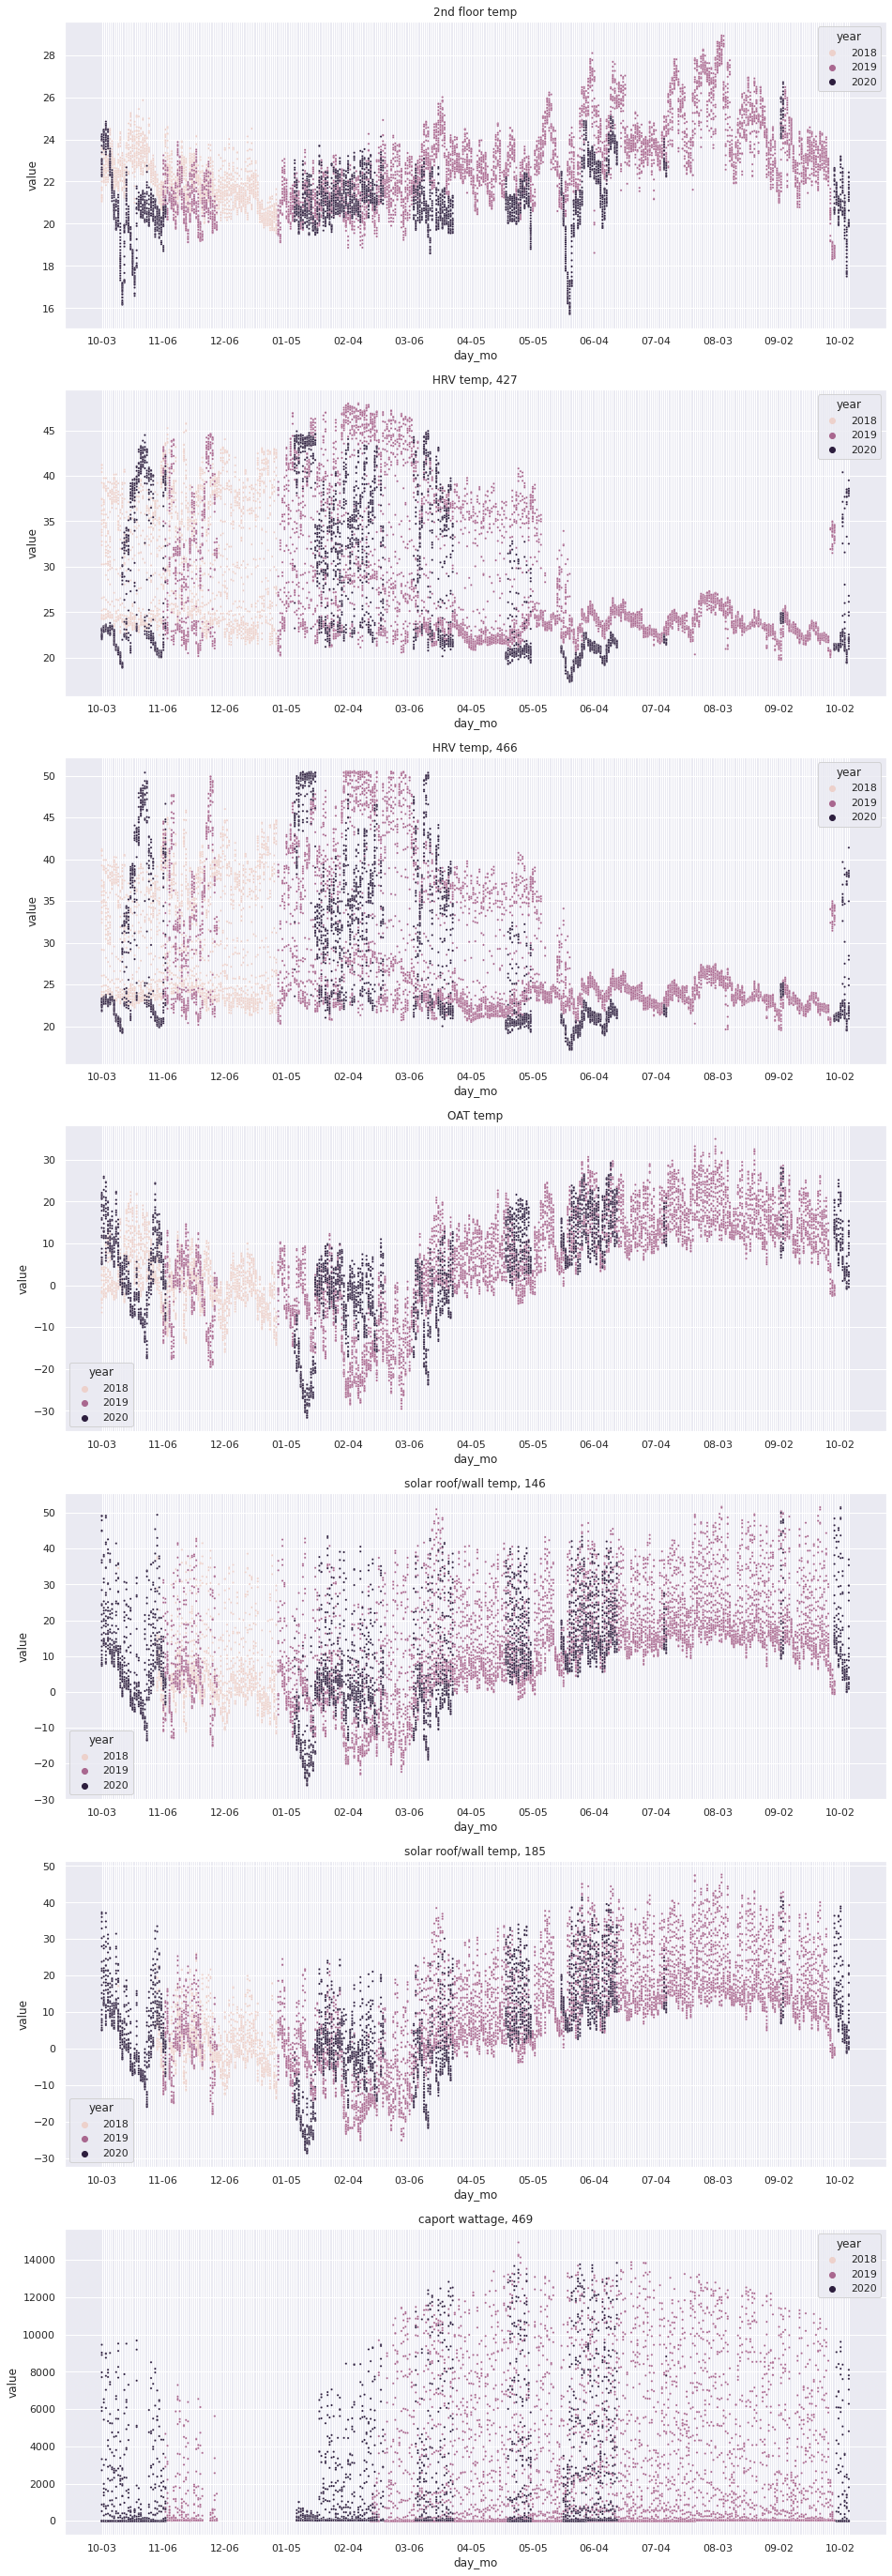

In [12]:
fig, ax = plt.subplots(nrows=7, ncols=1,figsize=(15.7,49.27))

# create year and day/month columns to use when plotting the data
combined_data_1hr_df['year'] = combined_data_1hr_df.index.year
combined_data_1hr_df['day_mo'] = combined_data_1hr_df.index.strftime('%m-%d')

# create separate dataframes for each of the sensors, for plotting
# 2nd floor temp
combined_data_df_406 = (combined_data_1hr_df[['read_value_406','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
# HRV temp
combined_data_df_427 = (combined_data_1hr_df[['read_value_427','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
combined_data_df_466 = (combined_data_1hr_df[['read_value_466','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
# oat temp
combined_data_df_173 = (combined_data_1hr_df[['read_value_173','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
# solar temp
combined_data_df_146 = (combined_data_1hr_df[['read_value_146','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
combined_data_df_185 = (combined_data_1hr_df[['read_value_185','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))
# carport wattage
combined_data_df_469 = (combined_data_1hr_df[['read_value_469','year','day_mo']]
                        .reset_index().melt(id_vars=['DateAndTimeIndex','year','day_mo']).set_index('DateAndTimeIndex'))


sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_406.reset_index(), 
                ax=ax[0], s=5).set_title('2nd floor temp')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_427.reset_index(), 
                ax=ax[1], s=5).set_title('HRV temp, 427')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_466.reset_index(), 
                ax=ax[2], s=5).set_title('HRV temp, 466')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_173.reset_index(), 
                ax=ax[3], s=5).set_title('OAT temp')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_146.reset_index(), 
                ax=ax[4], s=5).set_title('solar roof/wall temp, 146')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_185.reset_index(), 
                ax=ax[5], s=5).set_title('solar roof/wall temp, 185')
sns.scatterplot(x='day_mo', y='value', hue='year', data=combined_data_df_469.reset_index(), 
                ax=ax[6], s=5).set_title('caport wattage, 469')

# make x label a bit easier to read
for xax in ax:
  for ind, label in enumerate(xax.get_xticklabels()):
      if ind % 30 == 0:  # every 30th label is kept
        label.set_visible(True)
      else:
        label.set_visible(False)

###**NOTES/QUESTIONS**

- somewhat eary how the values from separate years align (seasonality at work)
  - can see that even carport is seasonal (less sun Nov-Jan)

- no 2018 data for the carport (built in 2019)
  - the trend looks like the two "halves" would meet somewhere around Dec 21/22 (solstice, longest night), but also could be that all of the the Nov-Jan caport data is under 2000 watts?
  - could we use univariate prediction to predict the missing data for the carport sensor? - probably better to get data from 2021 in the same time period

**is there a way to use the trends of other years to fill in the missing data in a specific year?**

- how would prediction work if we tried to just ignore the missing values in the time series, and decompose the datetime into day, month, and hours?
  - treat time series data as tabular data?



##consecutive block of data
At the end, we decided to build the model with the block of data that was continuous 
  - took couple attempts at imputations in different notebooks from available libraries in python and R, but the gaps are too large to fill in
  - creating tabular data as in section above still an option to try

In [36]:
# take the first two blocks of time for which we have all sensor data (from eda notebook)
con_data_1hr = combined_data_1hr_df[(combined_data_1hr_df.index >= pd.Timestamp('2019-02-22 15:00:00')) &
                                    (combined_data_1hr_df.index <= pd.Timestamp('2019-09-29 17:00:00'))]
# there is a missing row of data in between
con_data_1hr.isnull().sum()

fact_date         0
fact_time         0
read_value_406    1
read_value_427    1
read_value_466    1
read_value_173    1
read_value_469    1
read_value_146    0
read_value_185    0
temp_5am_173      0
dtype: int64

In [37]:
# check which values are missing
con_data_1hr[(con_data_1hr.index >= pd.Timestamp('2019-03-10 01:00:00')) &
                                    (con_data_1hr.index <= pd.Timestamp('2019-03-10 04:00:00'))]

,fact_date,fact_time,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185,temp_5am_173
DateAndTimeIndex,,,,,,,,,,
2019-03-10 01:00:00,2019-03-10,01:00:00,21.344827,26.823289,25.573496,-10.143744,-7.116667,-4.349790,-6.097960,-10.991022
2019-03-10 02:00:00,2019-03-10,02:00:00,NaN,NaN,NaN,NaN,NaN,-4.349790,-6.097960,-10.991022
2019-03-10 03:00:00,2019-03-10,03:00:00,21.171527,27.124267,26.238515,-10.864251,-7.016393,-4.835196,-6.644344,-10.991022
2019-03-10 04:00:00,2019-03-10,04:00:00,22.102984,43.047098,44.608567,-10.690470,-6.816667,-5.750277,-7.819976,-10.991022


In [38]:
# fill in the missing values using linear interpolation
con_data1 = con_data_1hr.interpolate()
# check new values
con_data1[(con_data1.index >= pd.Timestamp('2019-03-10 01:00:00')) &
                                    (con_data1.index <= pd.Timestamp('2019-03-10 04:00:00'))]

,fact_date,fact_time,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185,temp_5am_173
DateAndTimeIndex,,,,,,,,,,
2019-03-10 01:00:00,2019-03-10,01:00:00,21.344827,26.823289,25.573496,-10.143744,-7.116667,-4.349790,-6.097960,-10.991022
2019-03-10 02:00:00,2019-03-10,02:00:00,21.258177,26.973778,25.906005,-10.503997,-7.066530,-4.349790,-6.097960,-10.991022
2019-03-10 03:00:00,2019-03-10,03:00:00,21.171527,27.124267,26.238515,-10.864251,-7.016393,-4.835196,-6.644344,-10.991022
2019-03-10 04:00:00,2019-03-10,04:00:00,22.102984,43.047098,44.608567,-10.690470,-6.816667,-5.750277,-7.819976,-10.991022


In [39]:
con_data1.isnull().sum()

fact_date         0
fact_time         0
read_value_406    0
read_value_427    0
read_value_466    0
read_value_173    0
read_value_469    0
read_value_146    0
read_value_185    0
temp_5am_173      0
dtype: int64

In [40]:
# decompose the time features of the data (we already have date and time separated, but separate further)
con_data1['fact_day'] = con_data1.index.day
con_data1['fact_month'] = con_data1.index.month
con_data1['fact_hour'] = con_data1.index.hour

# rename columns for nicer user experience
con_data1 = con_data1.rename(columns={'read_value_406': '2nd_floor_406', 
                                      'read_value_427': 'HRV_north_427', 'read_value_466': 'HRV_south_466',
                                      'read_value_173': 'OAT_north_173', 
                                      'read_value_469': 'carport_pv_469',
                                      'read_value_146': 'solar_wall_146', 'read_value_185': 'solar_roof_185'})
con_data1

,fact_date,fact_time,2nd_floor_406,HRV_north_427,HRV_south_466,OAT_north_173,carport_pv_469,solar_wall_146,solar_roof_185,temp_5am_173,fact_day,fact_month,fact_hour
DateAndTimeIndex,,,,,,,,,,,,,
2019-02-22 15:00:00,2019-02-22,15:00:00,23.710943,22.711896,22.917343,1.151461,4641.016667,19.063403,7.708834,-15.552165,22,2,15
2019-02-22 16:00:00,2019-02-22,16:00:00,23.345989,22.569029,22.768495,1.431155,4329.400000,18.638129,7.934233,-15.552165,22,2,16
2019-02-22 17:00:00,2019-02-22,17:00:00,23.144977,22.413946,22.608923,-1.538001,714.500000,14.824185,7.356750,-15.552165,22,2,17
2019-02-22 18:00:00,2019-02-22,18:00:00,22.869214,40.433321,40.791459,-4.367817,-0.050000,4.763032,2.198453,-15.552165,22,2,18
2019-02-22 19:00:00,2019-02-22,19:00:00,22.659765,41.090683,41.134331,-5.559224,-7.600000,0.510342,-1.548033,-15.552165,22,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-29 13:00:00,2019-09-29,13:00:00,18.663595,33.354287,33.230902,-0.699912,16.966667,2.069570,-0.520678,-2.272964,29,9,13
2019-09-29 14:00:00,2019-09-29,14:00:00,18.754468,32.949105,32.982241,-0.554197,18.016667,2.157015,-0.267890,-2.272964,29,9,14
2019-09-29 15:00:00,2019-09-29,15:00:00,18.838911,32.982781,32.824640,-0.632683,12.650000,2.385787,-0.044953,-2.272964,29,9,15


In [18]:
# output the dataframe with the consecutive data block into a csv file on the computer
con_data1.to_csv('consecutive_data_block_220days_1hr_with5am.csv') 

from google.colab import files

files.download("consecutive_data_block_220days_1hr_with5am.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
create two files for "unseen" data validation

In [19]:
con_data_1hr_test1 = combined_data_1hr_df[(combined_data_1hr_df.index >= pd.Timestamp('2020-04-23 13:00:00')) &
                                    (combined_data_1hr_df.index <= pd.Timestamp('2020-05-04 23:00:00'))].copy()

con_data_1hr_test1[(con_data_1hr_test1.index >= pd.Timestamp('2020-04-23 13:00:00')) &
                                    (con_data_1hr_test1.index <= pd.Timestamp('2020-05-04 23:00:00'))]
con_data_1hr_test1.isnull().sum()

fact_date         0
fact_time         0
read_value_406    0
read_value_427    0
read_value_466    0
read_value_173    0
read_value_469    0
read_value_146    0
read_value_185    0
temp_5am_173      0
year              0
day_mo            0
dtype: int64

In [20]:
con_data_1hr_test2 = combined_data_1hr_df[(combined_data_1hr_df.index >= pd.Timestamp('2020-05-20 09:00:00')) &
                                    (combined_data_1hr_df.index <= pd.Timestamp('2020-06-15 19:00:00'))].copy()                          
con_data_1hr_test2[(con_data_1hr_test2.index >= pd.Timestamp('2020-05-20 09:00:00')) &
                                    (con_data_1hr_test2.index <= pd.Timestamp('2020-06-15 19:00:00'))]  
con_data_1hr_test2.isnull().sum()                                

fact_date         0
fact_time         0
read_value_406    0
read_value_427    0
read_value_466    0
read_value_173    0
read_value_469    0
read_value_146    0
read_value_185    0
temp_5am_173      0
year              0
day_mo            0
dtype: int64

In [41]:
# decompose the time features of this data to match the training set
con_data_1hr_test1['fact_day'] = con_data_1hr_test1.index.day
con_data_1hr_test1['fact_month'] = con_data_1hr_test1.index.month
con_data_1hr_test1['fact_hour'] = con_data_1hr_test1.index.hour

con_data_1hr_test2['fact_day'] = con_data_1hr_test2.index.day
con_data_1hr_test2['fact_month'] = con_data_1hr_test2.index.month
con_data_1hr_test2['fact_hour'] = con_data_1hr_test2.index.hour

# rename columns as well
con_data_1hr_test2 = con_data_1hr_test2.rename(columns={'read_value_406': '2nd_floor_406', 
                                                        'read_value_427': 'HRV_north_427', 'read_value_466': 'HRV_south_466',
                                                        'read_value_173': 'OAT_north_173', 
                                                        'read_value_469': 'carport_pv_469',
                                                        'read_value_146': 'solar_wall_146', 'read_value_185': 'solar_roof_185'})
con_data_1hr_test1 = con_data_1hr_test1.rename(columns={'read_value_406': '2nd_floor_406', 
                                                        'read_value_427': 'HRV_north_427', 'read_value_466': 'HRV_south_466',
                                                        'read_value_173': 'OAT_north_173', 
                                                        'read_value_469': 'carport_pv_469',
                                                        'read_value_146': 'solar_wall_146', 'read_value_185': 'solar_roof_185'})

In [42]:
con_data_1hr_test1

,fact_date,fact_time,2nd_floor_406,HRV_north_427,HRV_south_466,OAT_north_173,carport_pv_469,solar_wall_146,solar_roof_185,temp_5am_173,year,day_mo,fact_day,fact_month,fact_hour
DateAndTimeIndex,,,,,,,,,,,,,,,
2020-04-23 13:00:00,2020-04-23,13:00:00,20.711922,20.318326,20.111380,16.271350,12788.500000,29.726800,25.635671,3.532616,2020,04-23,23,4,13
2020-04-23 14:00:00,2020-04-23,14:00:00,20.890671,20.370685,20.185929,18.051819,11487.850000,34.254621,27.741799,3.532616,2020,04-23,23,4,14
2020-04-23 15:00:00,2020-04-23,15:00:00,21.043038,20.427032,20.251006,16.326001,6004.000000,34.439934,30.552676,3.532616,2020,04-23,23,4,15
2020-04-23 16:00:00,2020-04-23,16:00:00,21.117069,20.410327,20.208369,14.547343,7032.050000,27.629630,25.759816,3.532616,2020,04-23,23,4,16
2020-04-23 17:00:00,2020-04-23,17:00:00,21.163540,20.406588,20.201886,13.450143,3484.300000,24.265470,23.328804,3.532616,2020,04-23,23,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04 19:00:00,2020-05-04,19:00:00,19.155014,20.456203,20.600818,6.156424,615.716667,9.174165,8.024029,3.185162,2020,05-04,4,5,19
2020-05-04 20:00:00,2020-05-04,20:00:00,19.050934,20.308850,20.410327,5.968303,135.116667,8.301394,7.238494,3.185162,2020,05-04,4,5,20
2020-05-04 21:00:00,2020-05-04,21:00:00,18.949965,20.039577,20.044814,5.609591,-2.866667,7.589410,6.501809,3.185162,2020,05-04,4,5,21


In [23]:
# save the test files to computer
con_data_1hr_test1.to_csv('consecutive_data_block_220days_1hr_5am_test_data_1.csv') 
con_data_1hr_test2.to_csv('consecutive_data_block_220days_1hr_5am_test_data_2.csv') 

from google.colab import files

files.download("consecutive_data_block_220days_1hr_5am_test_data_1.csv")
files.download("consecutive_data_block_220days_1hr_5am_test_data_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
---
##Define the machine learning problem

Problem 1
- use data from 220 consecutive days (2019-02-22 to 2019-09-29) to predict hourly temperatures on the 2nd floor 4 hours ahead
  - e.g. you can predict what the temperature will be in the afternoon based on the data in the morning 
  - assume 8-5 workday
  - time window of 4 hours should be enough time to affect the temperature if any remedial action is taken
  




---
---
---
## notes on attempts from filling in missing values
Options explored:
- existing functions in python/R, 
- trying to implement custom function based on the theoretical algorithms in research papers, or 
- making arbitrary year's data from the average of the 3 values (there's just too many consecutive missing values)

Regular interpolation algorithms will not work because it is a time series with at least 2 seasonalities (and possibly trend - but wouldn't know this until have complete data for several years)

In [24]:
# according to https://pypi.org/project/impyute/ shoud have:
# Imputation of Time Series Data
#   Last Observation Carried Forward - not really applicable to our dataset
#   Moving Window
#   Autoregressive Integrated Moving Average (WIP) - they say they have it, but it is not in the API reference

# there is also https://scikit-learn.org/stable/modules/impute.html#impute 
# from sklearn.impute import <imputer name> - e.g. simple, iterative
# SimpleImputer not appropriate: "Missing values can be imputed with a provided constant value, or using the 
# statistics (mean, median or most frequent) of each column in which the missing values are located."
# "A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing 
# values as a function of other features, and uses that estimate for imputation. It does so in an iterated 
# round-robin fashion"

# or try and use R (e.g. imputeTS library) as has couple other methods
# Available imputation algorithms include:
# 'Mean', 'LOCF', 'Interpolation',
# 'Moving Average', 'Seasonal Decomposition',
# 'Kalman Smoothing on Structural Time Series models',
# 'Kalman Smoothing on ARIMA models'. 

# R is in a different notebook - for some reason it didn't work to run it in the same notebook as python using rpy2.ipython 

In [25]:
# example attempt using sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=256, random_state=42)

imputed = imputer.fit_transform(sensor_data_1hr_scaled)
sensor_data_1hr_trans = pd.DataFrame(imputed, columns=sensor_data_1hr_scaled.columns, index = sensor_data_1hr_scaled.index)

sensor_data_1hr_trans

,read_value_406,read_value_427,read_value_466,read_value_173,read_value_469,read_value_146,read_value_185
DateAndTimeIndex,,,,,,,
2018-10-03 00:00:00,0.419071,0.240841,0.207881,0.423763,-0.009846,0.387356,0.370648
2018-10-03 01:00:00,0.414087,0.233952,0.198017,0.424732,-0.013430,0.386621,0.370516
2018-10-03 02:00:00,0.409541,0.229665,0.191803,0.427829,-0.013048,0.387602,0.372287
2018-10-03 03:00:00,0.404209,0.225964,0.187338,0.423142,-0.018534,0.383606,0.367816
2018-10-03 04:00:00,0.475673,0.753155,0.697273,0.424037,0.053639,0.333400,0.344343
...,...,...,...,...,...,...,...
2020-11-07 19:00:00,0.383188,0.809410,0.882693,0.375374,0.002450,0.299713,0.301834
2020-11-07 20:00:00,0.384757,0.695551,0.738088,0.366994,0.002454,0.290644,0.291550
2020-11-07 21:00:00,0.385914,0.487939,0.413697,0.364277,0.002457,0.299516,0.288814


Text(0.5, 1.0, 'sensor data (normalized), 1 hour interval')

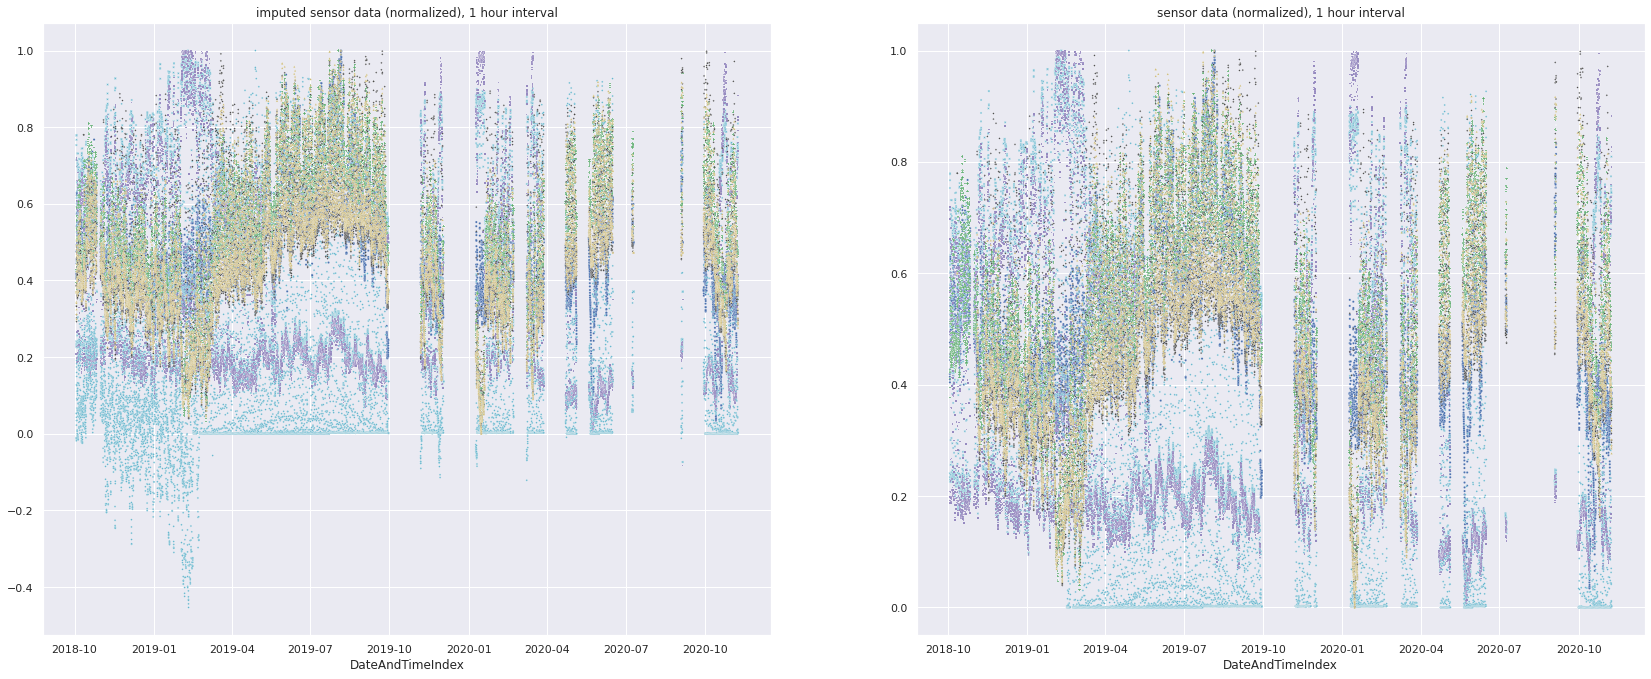

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(28.7,11.27))

sns.scatterplot(data=sensor_data_1hr_trans, palette=['b','c','m','g','c','k','y'],
                ax=ax[0], legend=False, s=5).set_title('imputed sensor data (normalized), 1 hour interval')
sns.scatterplot(data=sensor_data_1hr_scaled, palette=['b','c','m','g','c','k','y'],
                ax=ax[1], legend=False, s=5).set_title('sensor data (normalized), 1 hour interval')
# plt.legend(title='sensor_id', fontsize='14', title_fontsize='14')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=4, fancybox=True, shadow=True)

Not good - the theoretical minimum for the carport is -50 and the imputed values go well below that